<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/%5B0731new%5Dmachine_learning_for_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## memory 예측 (점진적 패턴, 느린 주기)
### 요청과 작업에 바로 반응하는 cpu와 달리 재사용을 위해 일정 기간 유지하기 때문

## 복잡한 memory 사용량 형태

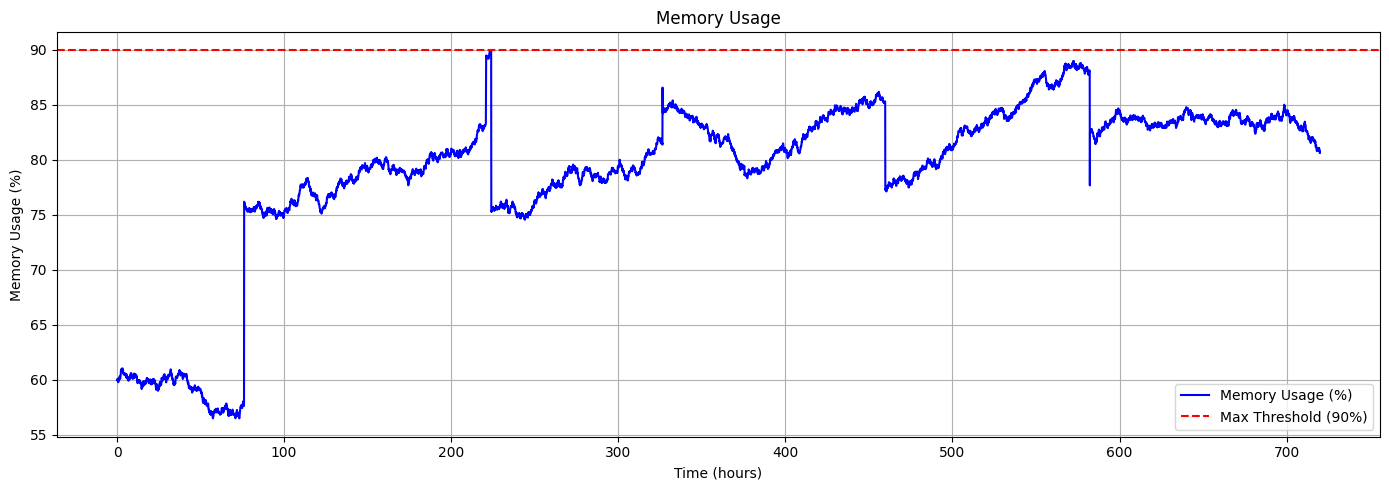

In [7]:
# 증설 필요한 상황
import numpy as np
import matplotlib.pyplot as plt

days = 30
interval_minutes = 5
steps_per_day = int(24 * 60 / interval_minutes)
total_steps = days * steps_per_day
time_hours = np.arange(total_steps) * (interval_minutes / 60)

baseline = 60
threshold = 90
growth_per_step = 0.001
small_noise_std = 0.1

gc_release_range = (5, 15)

# spike 설정
event_spikes = np.zeros(total_steps)
for _ in range(3):
    idx = np.random.randint(0, total_steps - 5)
    spike_val = np.random.uniform(3, 6)
    event_spikes[idx:idx+2] += spike_val

for _ in range(3):
    idx = np.random.randint(0, total_steps - 2)
    spike_val = np.random.uniform(40, 55)
    event_spikes[idx] += spike_val

memory_usage = []
current_mem = baseline

for i in range(total_steps):
    current_mem += growth_per_step + np.random.normal(0, small_noise_std) + event_spikes[i]

    # max threshold 초과하지 않도록 제한
    if current_mem > threshold:
        current_mem = threshold

    # GC 작동
    if current_mem >= threshold:
        release_amount = np.random.uniform(*gc_release_range)
        current_mem -= release_amount
        current_mem = max(current_mem, baseline)

    memory_usage.append(current_mem)

memory_usage = np.array(memory_usage)

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(time_hours, memory_usage, label="Memory Usage (%)", color='blue')
plt.axhline(threshold, color='red', linestyle='--', label="Max Threshold (90%)")
plt.title("Memory Usage")
plt.xlabel("Time (hours)")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# 하루 시간 반복을 위해 모듈로 24
hour_of_day = time_hours % 24

# 업무시간: 08:00 ~ 17:30
working_hour_mask = (hour_of_day >= 8.0) & (hour_of_day < 17.5)
working_hour_memory = memory_usage[working_hour_mask]
working_hour_avg = np.mean(working_hour_memory)

print(f"업무시간 메모리 평균 사용량: {working_hour_avg:.2f}%")


업무시간 메모리 평균 사용량: 78.79%


## 1. CNN-LSTM 적용 + sliding window(5)
### EX) 12*24*30 = 8640, 8640-20(past step)-5(future step) = 8615
### 8615*0.2 = 1723 stamp (전체 test 스탬프 수)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

days = 30
points_per_day = 24 * 12
total_points = days * points_per_day
time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
df = pd.DataFrame({'timestamp': time_index, 'memory': memory_usage}).set_index('timestamp')

scaler = MinMaxScaler()
memory_scaled =pd.DataFrame( scaler.fit_transform(df[['memory']]))

# 정규화는 train만 fit
split_point = int(len(memory_scaled) * 0.8)
df_train = memory_scaled.iloc[:split_point]
df_test = memory_scaled.iloc[split_point:]


# 시퀀스 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

# train/test 시퀀스 구성
X_train, y_train = create_sequences(df_train, past_steps, future_steps)
X_test, y_test = create_sequences(df_test, past_steps, future_steps)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), epochs=50, batch_size=16, verbose=1)

pred = model.predict(X_test).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0677
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 6.6193e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.4662e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.6047e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.3032e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 4.0935e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 4.6779e-04
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.5699e-04
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.9201e-04
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.6011e-04
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 4.3641e-04
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6712e-04
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 3.7729e-04
Epoch 14/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0004e-04
Epoch 15/50
4

CNN-LSTM
MAE : 0.21899366168034423
RMSE: 0.4041672293118919
R²  : 0.8589687603370756


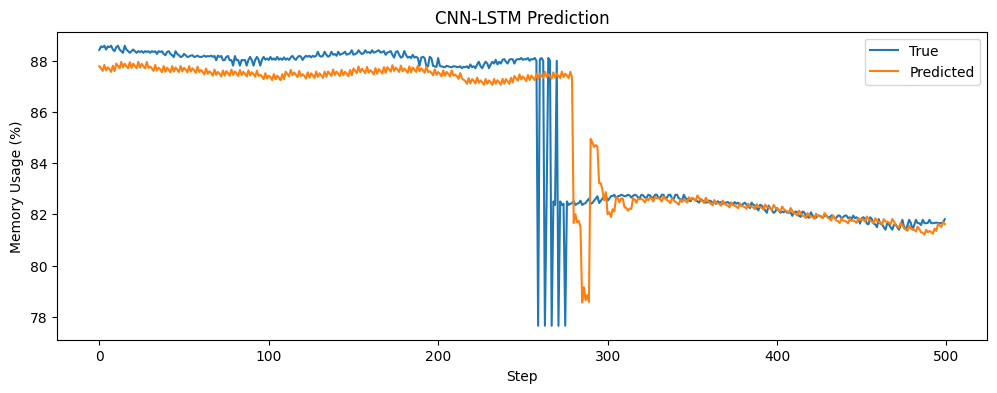

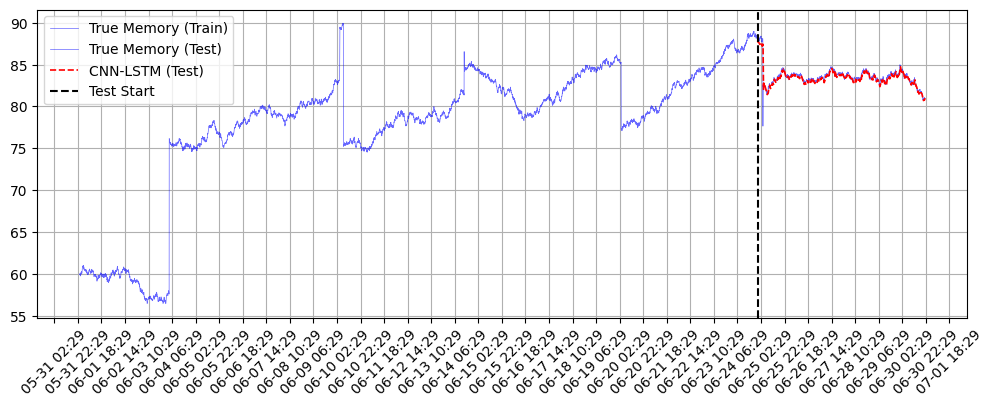

In [11]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200)) # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

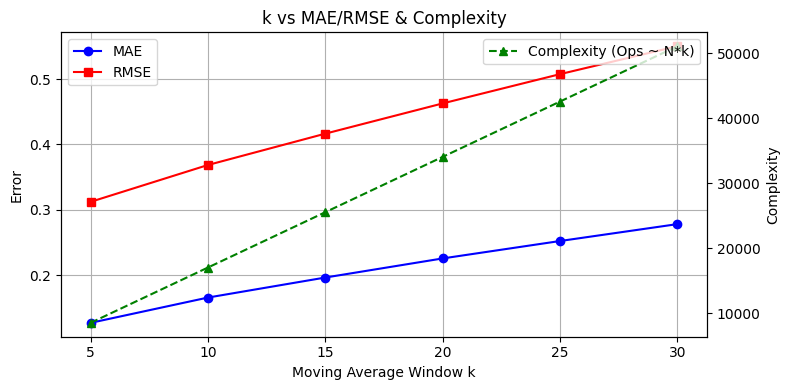

k= 5  MAE=0.1271  RMSE=0.3122  Complexity≈8515 ops
k=10  MAE=0.1659  RMSE=0.3686  Complexity≈17030 ops
k=15  MAE=0.1965  RMSE=0.4165  Complexity≈25545 ops
k=20  MAE=0.2257  RMSE=0.4627  Complexity≈34060 ops
k=25  MAE=0.2523  RMSE=0.5075  Complexity≈42575 ops
k=30  MAE=0.2782  RMSE=0.5503  Complexity≈51090 ops


In [12]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # (k, mae, rmse, complexity)

for k in k_list:
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # k step 이후
    true_vals_ma = test_series_true.values[k:]

    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    complexity = len(test_series_true) * k

    results.append((k, mae, rmse, complexity))

results_arr = np.array(results)
k_values = results_arr[:,0]
mae_values = results_arr[:,1]
rmse_values = results_arr[:,2]
complexity_values = results_arr[:,3]

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(k_values, mae_values, marker='o', label="MAE", color='blue')
ax1.plot(k_values, rmse_values, marker='s', label="RMSE", color='red')
ax1.set_xlabel("Moving Average Window k")
ax1.set_ylabel("Error")
ax1.grid(True)
ax1.legend(loc="upper left")

# complexity
ax2 = ax1.twinx()
ax2.plot(k_values, complexity_values, marker='^', label="Complexity (Ops ~ N*k)", color='green', linestyle='--')
ax2.set_ylabel("Complexity")
ax2.legend(loc="upper right")

plt.title("k vs MAE/RMSE & Complexity")
plt.tight_layout()
plt.show()

for k, mae, rmse, comp in results:
    print(f"k={int(k):2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{int(comp)} ops")


## 2. 단순 CNN

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


# 시퀀스 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

# train/test 시퀀스 구성
X_train, y_train = create_sequences(df_train, past_steps, future_steps)

# test는 train 마지막 20개와 test 앞부분을 이어붙여 구성
X_test, y_test = create_sequences(df_test, past_steps, future_steps)

# CNN-only 모델
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# reshape for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train_cnn, y_train, epochs=20, batch_size=16, verbose=1)
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)

pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0233
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.1864e-04
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9013e-04
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7767e-04
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6248e-04
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6692e-04
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1980e-04
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.8311e-04
Epoch 9/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.3252e-04
Epoch 10/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6389e-04
Epoch 11/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6139e-04
Epoch 12/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5037e-04
Epoch 13/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9899e-04
Epoch 14/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8939e-04
Epoch 15/20
431/

CNN
MAE : 0.17375116898391968
RMSE: 0.38252808299235946
R²  : 0.873610548945331


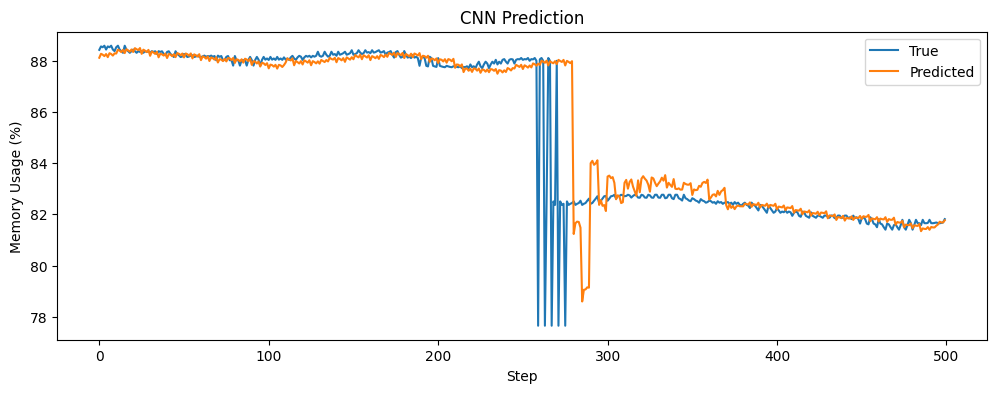

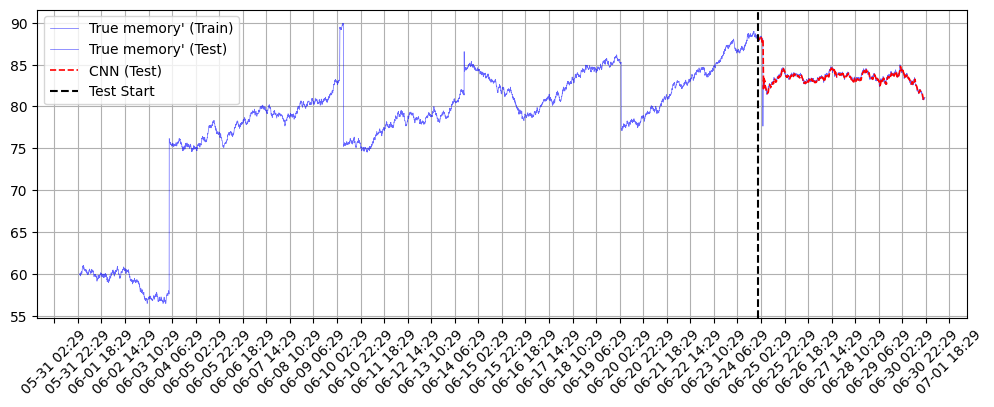

In [14]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True memory' (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True memory' (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200)) # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

## CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기

In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

# reshape y to match CNN-BiLSTM output
y_train_re = y_train.reshape(-1, future_steps)
y_test_re  = y_test.reshape(-1, future_steps)

# ✅ CNN-BiLSTM 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, activation='tanh')),
    Dense(future_steps)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ✅ reshape for Conv1D & LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ✅ 학습
model.fit(X_train_cnn, y_train_re, epochs=20, batch_size=16, verbose=1)

# ✅ 예측
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test_re.reshape(-1, future_steps)

# ✅ 복원 (정규화 → 원래 단위 [%]로)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

# ✅ 성능 출력
print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,949 (261.52 KB)

 Trainable params: 66,949 (261.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0298
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 6.5626e-04
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 9.1102e-04
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.0736e-04
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.6730e-04
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.0798e-04
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.9366e-04
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.9886e-04
Epoch 9/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.1492e-04
Epoch 10/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.0339e-04
Epoch 11/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.8318e-04
Epoch 12/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 3.6867e-04
Epoch 13/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.5944e-04
Epoch 14/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.

CNN-BiLSTM
MAE : 0.2306473860744897
RMSE: 0.4232804044999631
R²  : 0.8451819465035728


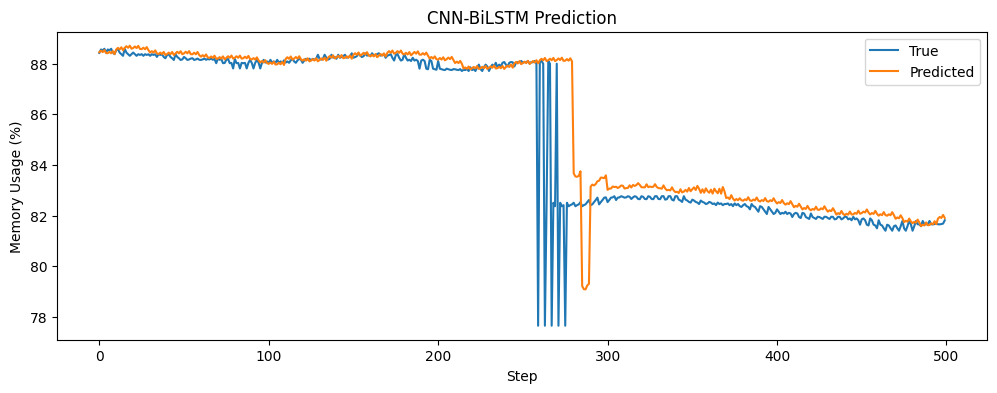

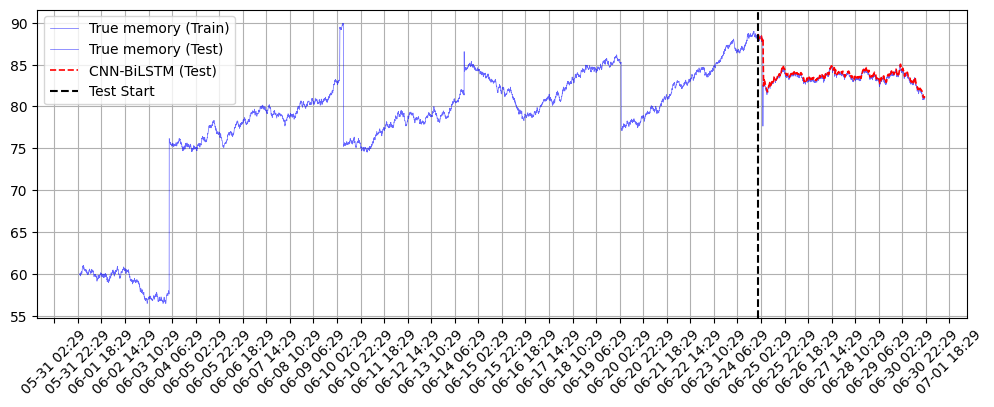

In [18]:
# plot

print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN-BiLSTM Prediction")
plt.ylabel("Memory Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['memory'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-BiLSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200)) # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

## FLNN + GA-PSO

In [ ]:
!pip install numpy deap pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.7 MB/s eta 0:00:00


/tmp/ipython-input-20-1768256710.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=len(memory_usage), freq='5T')
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
2025-07-29 05:25:29,136 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}


입력 X shape: (103674, 5) 출력 y shape: (103674,)
MAE for GA: 0.34089807701121244


pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.261
2025-07-29 05:25:31,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.26137165838623916, best pos: [ 0.64473019 -0.43319268 -0.01657753  0.61123263  0.18750402  0.59401213]


MAE for PSO: 0.26137165838623916


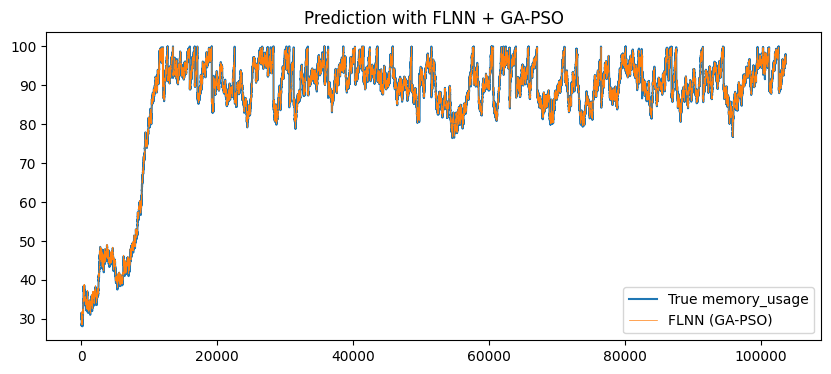

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# 위에서 생성한 memory_usage, time_hours 활용
time_index = pd.date_range('2025-06-01', periods=len(memory_usage), freq='5T')

df = pd.DataFrame({'timestamp': time_index, 'memory': memory_usage})
df.set_index('timestamp', inplace=True)

# sliding window(1)
past_steps = 5
future_steps = 1

# sequence for data
X, y = [], []
for i in range(len(memory_usage)-past_steps-future_steps):
    X.append(memory_usage[i:i+past_steps])
    y.append(memory_usage[i+past_steps: i+past_steps+future_steps])
X = np.array(X)
y = np.array(y).flatten()

print("입력 X shape:", X.shape, "출력 y shape:", y.shape)

# FLNN 예측 : 입력 x에 대해 가중치 적용
def flnn_predict(weights, X):
    bias = weights[-1]
    return np.dot(X, weights[:-1]) + bias

from deap import base, creator, tools, algorithms

input_dim = past_steps
pop_size = 20
num_generations = 10

# 적합도: MAE 최소화
def eval_mae(individual):
    y_pred = flnn_predict(np.array(individual), X)
    return (np.abs(y - y_pred).mean(),)  # 튜플 반환

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=input_dim+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval_mae)

pop = toolbox.population(n=pop_size)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)

# GA
best_ga = tools.selBest(pop, 1)[0]
print("MAE for GA:", eval_mae(best_ga)[0])

import pyswarms as ps

def pso_objective(w):
    # w: (num_particles, num_weights)
    losses = []
    for particle in w:
        y_pred = flnn_predict(particle, X)
        losses.append(np.abs(y - y_pred).mean())

    return np.array(losses)

# initial PSO
num_particles = 20
num_weights = input_dim + 1  # past_steps + bias

x_init = np.tile(best_ga, (num_particles, 1)) + np.random.normal(0, 0.1, (num_particles, num_weights))

options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}

optimizer = ps.single.GlobalBestPSO(
    n_particles=num_particles,
    dimensions=num_weights,
    options=options,
    init_pos=x_init
)

best_cost, best_pso = optimizer.optimize(pso_objective, iters=100)

print("MAE for PSO:", best_cost)

import matplotlib.pyplot as plt

# GA + PSO 함께 적용
final_weights = best_pso
y_pred = flnn_predict(final_weights, X)

plt.figure(figsize=(10,4))
plt.plot(y, label="True memory_usage")
plt.plot(y_pred, label="FLNN (GA-PSO)",linewidth = 0.5)
plt.legend()
plt.title("Prediction with FLNN + GA-PSO")
plt.show()


Result for Moving Average
MAE : 0.4593
RMSE: 0.7304

Aligned GA-PSO
MAE : 0.2473
RMSE: 0.4105


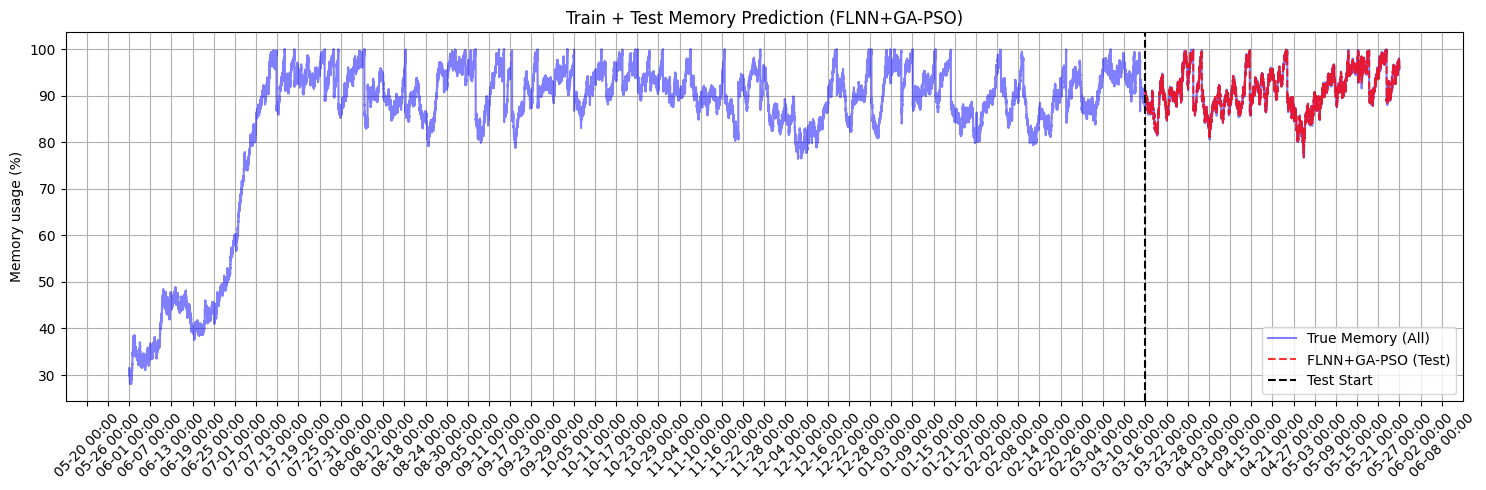

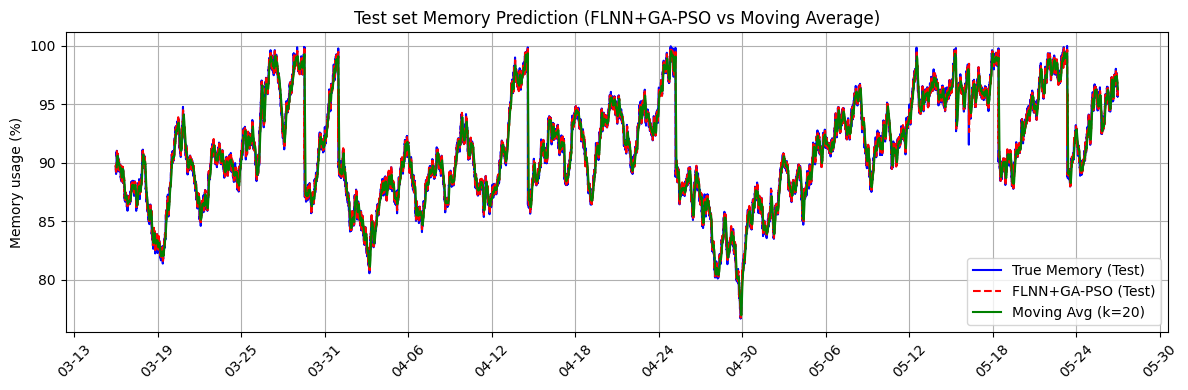

In [ ]:
split_ratio = 0.8
split_idx = int(len(y) * split_ratio)

# Train, Test split
train_true = y[:split_idx]
test_true  = y[split_idx:]
train_pred = y_pred[:split_idx]
test_pred  = y_pred[split_idx:]

# time index
time_index_all = df.index[past_steps : past_steps + len(y)]
train_time_index = time_index_all[:split_idx]
test_time_index  = time_index_all[split_idx:]

# Evaluation
aligned_test_pred = test_pred[k:]
aligned_test_true = test_true[k:]

k = 20
ma_pred = [np.mean(test_true[i-k:i]) for i in range(k, len(test_true))]
ma_true_vals = test_true[k:]
mae_ma  = mean_absolute_error(ma_true_vals, ma_pred)
rmse_ma = np.sqrt(mean_squared_error(ma_true_vals, ma_pred))
print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")

mae_ga_pso_aligned  = mean_absolute_error(aligned_test_true, aligned_test_pred)
rmse_ga_pso_aligned = np.sqrt(mean_squared_error(aligned_test_true, aligned_test_pred))
print("\nAligned GA-PSO")
print(f"MAE : {mae_ga_pso_aligned:.4f}")
print(f"RMSE: {rmse_ga_pso_aligned:.4f}")

# mae_ga_pso  = mean_absolute_error(test_true, test_pred)
# rmse_ga_pso = np.sqrt(mean_squared_error(test_true, test_pred))
# print("\nResult for FLNN+GA-PSO")
# print(f"MAE : {mae_ga_pso:.4f}%")
# print(f"RMSE: {rmse_ga_pso:.4f}%")

plt.figure(figsize=(15,5))

plt.plot(time_index_all, y, label="True Memory (All)", color="blue", alpha=0.5)
plt.plot(test_time_index, test_pred, label="FLNN+GA-PSO (Test)", color="red", linestyle="--", alpha=0.8)

# start line for test datset
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")

# x축 legend 시간 간격 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
# plt.setp(ax.get_xticklabels(), rotation=90)
plt.xticks(rotation=45)
plt.ylabel("Memory usage (%)")
plt.title("Train + Test Memory Prediction (FLNN+GA-PSO)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# test data 부분만 따로 plot
plt.figure(figsize=(12,4))
plt.plot(test_time_index, test_true, label="True Memory (Test)", color="blue")
plt.plot(test_time_index, test_pred, label="FLNN+GA-PSO (Test)", color="red", linestyle="--")
plt.plot(test_time_index[k:], ma_pred, label=f"Moving Avg (k={k})", color="green", linestyle="-", linewidth = 1.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel("Memory usage (%)")
plt.title("Test set Memory Prediction (FLNN+GA-PSO vs Moving Average)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

aligned_test_pred = test_pred[k:]
aligned_test_true = test_true[k:]



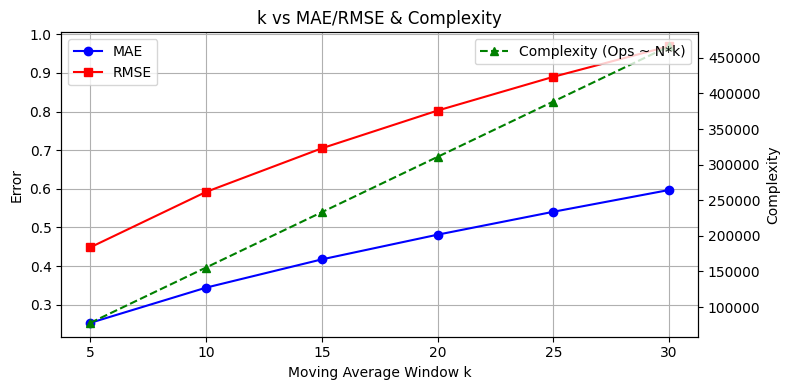

k= 5  MAE=0.2532  RMSE=0.4486  Complexity≈77735 ops
k=10  MAE=0.3443  RMSE=0.5920  Complexity≈155470 ops
k=15  MAE=0.4175  RMSE=0.7049  Complexity≈233205 ops
k=20  MAE=0.4814  RMSE=0.8026  Complexity≈310940 ops
k=25  MAE=0.5407  RMSE=0.8899  Complexity≈388675 ops
k=30  MAE=0.5971  RMSE=0.9692  Complexity≈466410 ops


In [ ]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # (k, mae, rmse, complexity)

for k in k_list:
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # k step 이후
    true_vals_ma = test_series_true.values[k:]

    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    complexity = len(test_series_true) * k

    results.append((k, mae, rmse, complexity))

results_arr = np.array(results)
k_values = results_arr[:,0]
mae_values = results_arr[:,1]
rmse_values = results_arr[:,2]
complexity_values = results_arr[:,3]

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(k_values, mae_values, marker='o', label="MAE", color='blue')
ax1.plot(k_values, rmse_values, marker='s', label="RMSE", color='red')
ax1.set_xlabel("Moving Average Window k")
ax1.set_ylabel("Error")
ax1.grid(True)
ax1.legend(loc="upper left")

# complexity
ax2 = ax1.twinx()
ax2.plot(k_values, complexity_values, marker='^', label="Complexity (Ops ~ N*k)", color='green', linestyle='--')
ax2.set_ylabel("Complexity")
ax2.legend(loc="upper right")

plt.title("k vs MAE/RMSE & Complexity")
plt.tight_layout()
plt.show()

for k, mae, rmse, comp in results:
    print(f"k={int(k):2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{int(comp)} ops")


## 기간 및 모델 별 결과 비교 그래프 (Mov_avg, CNN_LSTM, FLNN) (30,90,180,270,360일)

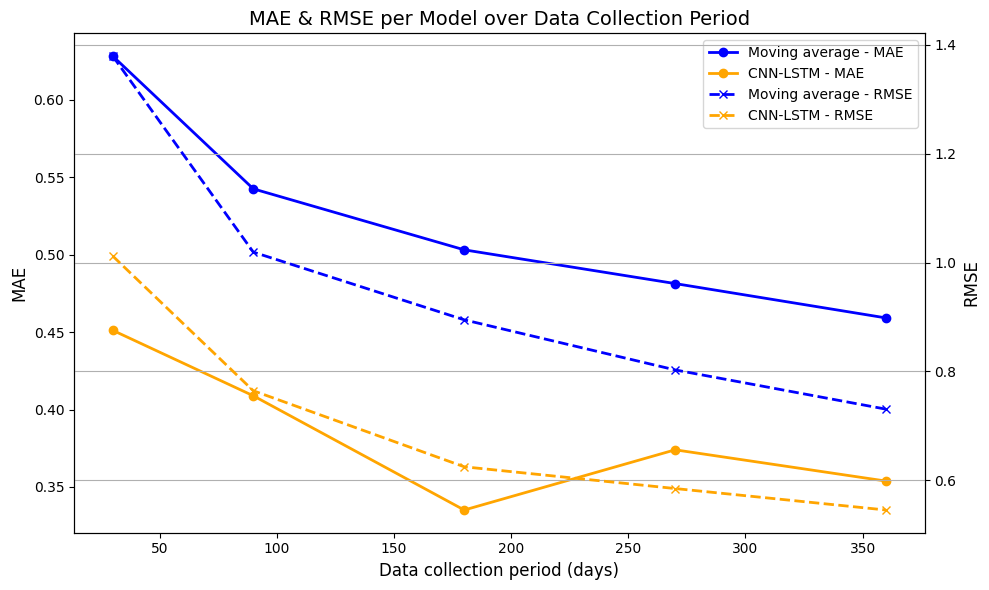

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 정의
periods = [30, 90, 180, 270, 360]

# mae_data = {
#     'Moving average': [0.6932, 0.7308, 0.6416, 0.6927, 0.6569],
#     'CNN-LSTM': [0.6053, 0.4928, 0.4415, 0.4464, 0.4063],
#     'FLNN_GA': [0.4103, 0.3652, 0.2663, 0.2296, 0.3616]
# }

# rmse_data = {
#     'Moving average': [1.6116, 1.6280, 1.5035, 1.6532, 1.5131],
#     'CNN-LSTM': [1.4071, 1.1906, 0.9829, 1.0515, 0.9680],
#     'FLNN_GA': [1.2347, 1.1979, 0.8300, 0.7540, 1.0528]
# }

mae_data = {
    'Moving average': [0.6284,0.5426,0.5032,0.4814,0.4592],
    'CNN-LSTM': [0.4512,0.4089,0.3351,0.374,0.3538],
    # 'FLNN_GA': [0.2445,0.2239,0.2197,0.2276,0.2473]
}

rmse_data = {
    'Moving average': [1.3797,1.0192,0.8947,0.8026,0.7304],
    'CNN-LSTM': [1.012,0.7643,0.6245,0.5845,0.545],
    # 'FLNN_GA': [0.6042,0.4789,0.4429,0.404,0.4105]
}

# 2. 색상 고정
colors = {
    'Moving average': 'blue',
    'CNN-LSTM': 'orange',
    # 'FLNN_GA': 'green'
}

# 3. 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()  # 오른쪽 y축

for model in mae_data:
    ax1.plot(periods, mae_data[model], marker='o', label=f'{model} - MAE', color=colors[model], linewidth=2)
    ax2.plot(periods, rmse_data[model], marker='x', linestyle='--', label=f'{model} - RMSE', color=colors[model], linewidth=2)

# 축 설정
ax1.set_xlabel("Data collection period (days)", fontsize=12)
ax1.set_ylabel("MAE", color='black', fontsize=12)
ax2.set_ylabel("RMSE", color='black', fontsize=12)

# 범례 합치기
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=10)

plt.title("MAE & RMSE per Model over Data Collection Period", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
